## MEAM 5460 Project 1: Blade Element Momentum Theory
### Author: Nathaniel Ruhl

### 1) Introduction

In this report, I expand the BEMT tool first developed in Homework 3. BEMT is such a powerful tool because it enables us accurately model, analyze, and optimize different rotor blade designs without too many assumptions. In this report, we will break some of the assumptions used in [Homework 3](https://github.com/nruhl25/HoveringVehicleDesign/blob/main/hw3/hw3_report.ipynb). We are still considering a rotor in hover, but we consider linear variations of the following rotor properties: rotor twist distribution $\theta(r)$, blade section chord length $c(r)$, and linear airfoil lift-curve slopes $c_{l,\alpha}$. The enumerated list below shows the key factors and models built into the "BEMT2" tool.

1. The rotor is in hover: $\lambda_c = 0$
2. Linear twist distribution, specified by input collective at 75%R and the linear twist rate: $\theta(r) = \theta_{75} + \theta_{tw}(r-0.75)$
3. Linear taper of local blade chord, specified by the chord at 75%R and the taper rate (TR): $c(r) = c_{75}-TR(r-0.75)$
4. Linear airfoil lift-curve slopes, specified by the slope at 75%R and the airfoil varitation root-to-tip (AV): $c_{l,\alpha}(r)=c_{l,\alpha}^{(75)}+AV(r-0.75)$
5. The Prandtl tip loss factor, $0<F<1$, describes the increase of induced velocity near the rotor tip

This list can be directly compared to the enumerated list in my [Homework 3 Report](https://github.com/nruhl25/HoveringVehicleDesign/blob/main/hw3/hw3_report.ipynb) in order to better understand the additions to the update BEMT tool.

### 2) The "Rotor2" class and baseline test rotor specifications

The test rotor specifications that will be considered in this report are used as the default instance properties in the "Rotor2" class. The default properties are

- $N_b$ = 1
- $R$ = 30 ft
- $v_{tip}$ = 780 ft/sec

and the (property) coefficients defining the linear variations are

__Twist distribution__:
- $\theta_{75}=5^\circ$ (I define this because the assignment does not specify)
- $\theta_{tw}=-8^\circ$ per non-dimensional radius

__Taper__:
- $c_{75} = 2$ ft
- $TR = 0.5$ ft per non-dimensional radius

__Airfoil variation__:
- $c_{l,\alpha}^{(75)}=2\pi$
- $AV=0$ per non-dimensional radius







### 3) BEMT Equations and the Prandtl Tip Loss Factor

This section builds off the discussion in [Homework 3 Report](https://github.com/nruhl25/HoveringVehicleDesign/blob/main/hw3/hw3_report.ipynb), which can be referenced if additional information is needed regarding the BEMT Equations. Here, we focus on the adition of Prandtl's Tip Loss Function to BEMT. The purpouse of Prandtl's $F$ function is to increase the induced velocity and reduce the lift generated near the tip of a blade, which is an effect associated with a rotor having a finite number of blades. These losses can be captured in the factor $F$:

$$F = \left( \frac{2}{\pi} \right) \cos^{-1}(\exp(-f))$$

where $f$ depends on the number of blades and the radial position of the blade element $r$,

$$f = \frac{N_b}{2}\left( \frac{1-r}{r \phi(r)}\right)$$

and $\phi(r)=\lambda(r)/r$ is the induced inflow angle. 

With the addition of the tip loss function, the local thrust and induced power coefficients can be written as 

$$c_T = 4 F \lambda(r)^2 r$$
$$c_P = 4 F \lambda(r)^3 r.$$

The total coefficients of thrust and power can then be determined by the numerical integrals

$$C_T = 4 \int_0^1 \lambda(r)^2 r dr$$
$$C_P = 4 \int_0^1 \lambda(r)^3 r dr$$.

By equating the local thrust coefficients from momentum and blade element theories, it can be shown that

$$\lambda(r) = \frac{\sigma c_{l,\alpha}(r)}{16 F} \left( \sqrt{1+\frac{32 F}{\sigma(r) c_{l,\alpha}(r)} \theta(r) r} - 1 \right) $$

where the linear variations of $c_{l,\alpha}(r)$, $\theta(r)$ are given in Section 2, and the solidity $\sigma(r)$ is also a linear function dictated by the chord variation (taper):

$$\sigma(r) = \frac{N_b c(r)}{\pi R}.$$

It should be noted that although $\lambda$ depends explicitly on $F$, $F$ is also a function of $\lambda$. Therefore, $\lambda$ must be calculated iteratively using $F=1$ as a starting point.

### 4) Analysis

This analysis makes use of the modules, classes, and functions imported in the cell block below. It should be noted that I often used upper case greek letters as function definitions and that $c_T(r)=$`dCT(R)` and $c_P=$`dCP(r)` in the code. The functions also take inputs of a Rotor object and $F$, and you can write `Theta?` in a code cell to see information about the $\theta(r)$ function.

Lastly, the two codebloacks below are all that is needed to use this tool. The "rotor" object can be changed dynamically as the user desires (although it is always good to confirm that you are correctly changing the rotor object in the Kernel memory, and re-run the `importlib.reload()` lines if changes are made to the scripts).

In [1]:
# import standard libraries
import importlib
import numpy as np
import matplotlib.pyplot as plt

# import local modules (these scripts must be in the working directory)
from Rotor2 import Rotor2  # Rotor class definition
import BEMT2   # BEMT2 tool
importlib.reload(BEMT2)
from BEMT2 import Cl_slope, Theta, Chord, Sigma, Lambda, Alpha, Phi, dCT, dCP, calc_CT_CP, calcF

In [2]:
rotor2 = Rotor2()
rs = np.linspace(0.1,0.99,100)  # Non-dimensional radius, shortened at ends to avoid discontinuities

### Addition of Prandtl Tip Loss

Text(0, 0.5, 'F')

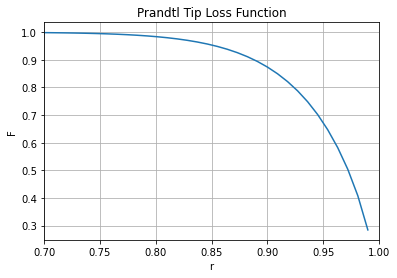

In [3]:
rotor2.Nb=1
rotor2.theta_tw=0 # UNTWISTED BLADE!! (page 144)
F_list = np.zeros(100)
lambda_list = np.zeros(100)
dCT_list = np.zeros(100)
dCP_list = np.zeros(100)
for i in range(len(rs)):
    F = calcF(rs[i], rotor2)
    F_list[i] = F
    lambda_list[i] = Lambda(rs[i], rotor2, F)
    dCT_list[i] = dCT(rs[i], rotor2, F)
    dCP_list[i] = dCP(rs[i], rotor2, F)

plt.title("Prandtl Tip Loss Function")
plt.plot(rs, F_list)
plt.grid()
plt.xlim([0.7,1])
plt.xlabel('r')
plt.ylabel('F')

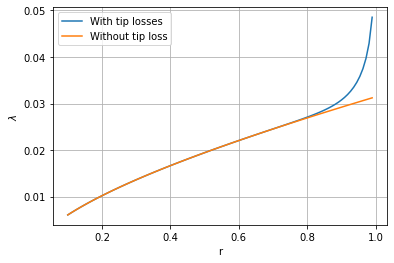

In [4]:
plt.plot(rs, lambda_list, label="With tip losses")
plt.plot(rs, Lambda(rs, rotor2, F=1), label="Without tip loss")
plt.grid()
plt.xlabel('r')
plt.ylabel(r'$\lambda$')
plt.legend()

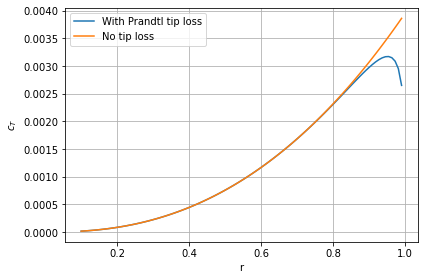

In [5]:
plt.plot(rs, dCT_list, label="With Prandtl tip loss")
plt.plot(rs, dCT(rs, rotor2, F=1), label="No tip loss")
plt.grid()
plt.xlabel('r')
plt.ylabel(r'$c_T$')
plt.legend()
plt.tight_layout()

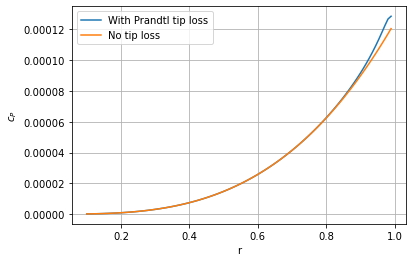

In [6]:
plt.plot(rs, dCP_list, label="With Prandtl tip loss")
plt.plot(rs, dCP(rs, rotor2, F=1), label="No tip loss")
plt.grid()
plt.xlabel('r')
plt.ylabel(r'$c_P$')
plt.legend()

### Validation of Test Rotors (1-4)

In order to ascertain whether the tool is giving the correct results, and to demonstrate how to use the functions, we will consider the 4 test rotors given in the project assignment. The changes to the rotor properties identified below alter the default rotor2 definition.

#### Rotor 1: Constant chord of 2 ft with constant airfoil

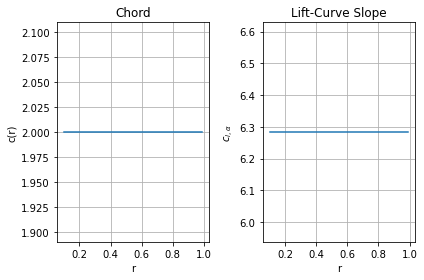

In [31]:
rotor2 = Rotor2()  # Make sure we reset to defaults

rotor2.chord_75 = 2
rotor2.TR = 0

rotor2.cl_slope_75 = 2*np.pi
rotor2.AV = 0

plt.subplot(1,2,1)
plt.title("Chord")
plt.ylabel("c(r)")
plt.xlabel("r")
plt.plot(rs, Chord(rs, rotor2))
plt.grid()

plt.subplot(1,2,2)
plt.title("Lift-Curve Slope")
plt.ylabel(r"$c_{l,\alpha}$")
plt.xlabel("r")
plt.plot(rs, Cl_slope(rs, rotor2))
plt.grid()

plt.tight_layout()

In [8]:
# Further analysis on each rotor

#### Rotor 2: Constant chord of 2 ft with varying airfoils: $c_{l,\alpha}=2\pi$ at root and $c_{l,\alpha}=6.0$ at tip

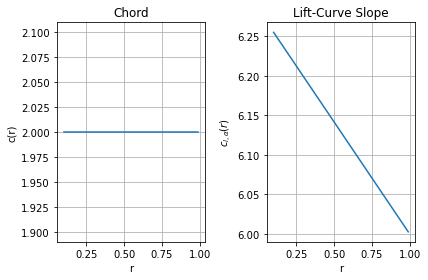

In [33]:
rotor2 = Rotor2()

rotor2.chord_75 = 2
rotor2.TR = 0

rotor2.AV = 6-2*np.pi
rotor2.cl_slope_75 = 2*np.pi+0.75*(6.0-2*np.pi)

plt.subplot(1,2,1)
plt.title("Chord")
plt.ylabel("c(r)")
plt.xlabel("r")
plt.plot(rs, Chord(rs, rotor2))
plt.grid()

plt.subplot(1,2,2)
plt.title("Lift-Curve Slope")
plt.ylabel(r"$c_{l,\alpha}(r)$")
plt.xlabel("r")
plt.plot(rs, Cl_slope(rs, rotor2))
plt.grid()

plt.tight_layout()

In [10]:
# Further analysis

#### Rotor 3: 2:1 taper ratio (2ft chord at 75%R) with constant airfoil, $c_{l,\alpha}=2\pi$

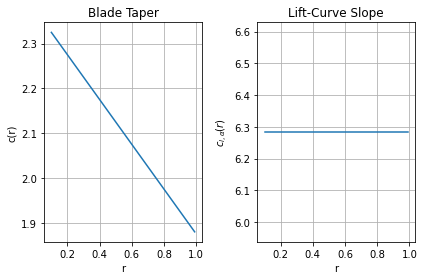

In [36]:
rotor2 = Rotor2()

rotor2.TR = -0.5
rotor2.chord_75 = 2  # ft

plt.subplot(1,2,1)
plt.title("Blade Taper")
plt.ylabel("c(r)")
plt.xlabel("r")
plt.plot(rs, Chord(rs, rotor2))
plt.grid()

plt.subplot(1,2,2)
plt.title("Lift-Curve Slope")
plt.xlabel("r")
plt.ylabel(r"$c_{l,\alpha}(r)$")
plt.plot(rs, Cl_slope(rs, rotor2))
plt.grid()

plt.tight_layout()

In [37]:
Chord(1, rotor2)-Chord(0, rotor2)

## I NEED TO FICX MY TAPER

-0.5

#### Rotor 4: 2:1 taper ratio (2 ft chord at 0.75R) with varying airfoils, $c_{l,\alpha}=2\pi$ at root and $c_{l,\alpha}=6.0$

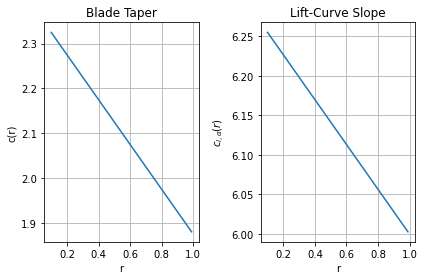

In [39]:
rotor2 = Rotor2()

rotor2.TR = -0.5
rotor2.chord_75 = 2  # ft

rotor2.AV = 6-2*np.pi
rotor2.cl_slope_75 = 2*np.pi+0.75*(6.0-2*np.pi)

plt.subplot(1,2,1)
plt.title("Blade Taper")
plt.ylabel("c(r)")
plt.xlabel("r")
plt.plot(rs, Chord(rs, rotor2))
plt.grid()

plt.subplot(1,2,2)
plt.title("Lift-Curve Slope")
plt.xlabel("r")
plt.ylabel(r"$c_{l,\alpha}(r)$")
plt.plot(rs, Cl_slope(rs, rotor2))
plt.grid()

plt.tight_layout()